In [85]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, save_or_load_onehot, build_data, plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison, extract_and_average)
from utils.utils_model_full_tensor import Network, visualize_layers, train, evaluate


import wandb

from sklearn.metrics import r2_score, mean_squared_error

plt.rcParams["mathtext.fontset"] = "cm"

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


## load data
# data_file = '../dataset/openmx_data_20250319_152811.pkl'
data_file = '../dataset/symmetrized_permittivity.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')



energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 201 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df['real_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['real_symmetrized_permittivity'], row['omega']) for _, row in df.iterrows()
]

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

perm_matrices_tensor = torch.tensor(np.stack(df['real_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


## Processed atom feature
def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius


type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

# Find the scaling value
tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print(tmp.shape)
# mean_data = np.mean(np.max(tmp, axis=1))
# std_data = np.std(np.max(tmp, axis=1))
# print(mean_data)
# print(std_data) 
# scale_data = np.median(np.max(tmp, axis=1))
scale_data = np.median(np.max(np.abs(tmp), axis=(1, 2)))
# scale_data = 1 
print(scale_data)


r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data, type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding, r_max), axis=1)

run_time = '250406'
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)


## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, num_crystal_systems=7, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        # self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_crystal_system = nn.Linear(num_crystal_systems, em_dim)  # Linear layer for crystal system
        self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        # data.x = F.relu(self.em_x(data.x))

        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        crystal_system_embed = F.relu(self.em_crystal_system(data.crystal_system_onehot))  # Shape: (em_dim,)
        num_nodes = data.x_mass.shape[0]
        if hasattr(data, 'batch') and data.batch is not None:
            crystal_system_embed = crystal_system_embed[data.batch]  # Shape: (num_nodes, em_dim)
        else:
            # Single graph case: repeat for all nodes
            crystal_system_embed = crystal_system_embed.squeeze(0).repeat(num_nodes, 1)  # Shape: (num_nodes, em_dim)    
            
        # tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius, crystal_system_embed], dim=0)  # Shape: (4, num_nodes, em_dim)        
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)  # Shape: (3, num_nodes, em_dim)        

        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # RELU issue, from e3nn discussion, removing because it might break the symmetry
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # take mean over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples
        return output

out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64


use_batch_norm = False
dropout_prob=0

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e +" + str(out_dim) + "x2e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train.mean(),
    reduce_output=True,
    dropout_prob=dropout_prob,
    use_batch_norm = use_batch_norm
)
run_name = f'symmetrized_data_model_re_{run_time}'
# run_name = f'symmetrized_data_model_re_sph_coefs_soa'
# run_name = f'with_equivariant_model_re_{run_time}'

wandb.init(
    project="Inference",  # Change this to your project name
    name=run_name,  # Unique identifier for this run
    config={
    }
)

# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse_sph'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

# weight = torch.abs(model.em_mixing.weight) / (torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True) + 1e-10)
# wandb.log({"model_weights": wandb.Histogram(weight.detach().cpu().numpy())})
# print(weight)
predictions = [] 
df['y_pred_sph'] = None
i0 = 0
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        
        irreps_0e = model.irreps_out.count(o3.Irrep("0e"))
        irreps_2e = model.irreps_out.count(o3.Irrep("2e")) * 5
        out_dim = model.irreps_out.count(o3.Irrep("0e")) 
        
        output_0e = output[:, :irreps_0e]  # Shape: (batch_size, irreps_0e)
        output_2e = output[:, irreps_0e:irreps_0e + irreps_2e].contiguous().view(output.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        y_0e = d.y[:, :, 0].view(d.y.shape[0], out_dim) 
        y_2e = d.y[:, :, 1:].view(d.y.shape[0], out_dim, 5)  # Shape: (batch_size, 201, 5)

        loss_0e = F.mse_loss(output_0e, y_0e)   # MSE or other suitable loss
        loss_2e = F.mse_loss(output_2e, y_2e)   # MSE or other suitable loss
        loss = loss_0e + loss_2e
        
        combined_output = torch.cat([output_0e.unsqueeze(2), output_2e], dim=2)  # Shape: (batch_size, 201, 6)
        predictions.append(combined_output.cpu())

        for batch_idx in range(d.y.shape[0]):
            df.loc[i0 + batch_idx, 'y_pred_sph'] = [combined_output[batch_idx].cpu().numpy()]
            # df.loc[i0 + batch_idx, 'y_pred_cart'] = [realsphvec2cart(combined_output[batch_idx].cpu().numpy())]
            df.loc[i0 + batch_idx, 'mse_sph'] = loss.cpu().numpy() * scale_data

        # Update batch index counter
        i0 += d.y.shape[0]

column = 'real_Permittivity_Matrices_interp'

df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0]) * scale_data

# perm_cartesian_tensor = x.to_cartesian(sph_coefs_tensor)

# Convert all spherical tensors to a batched tensor
sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  # Batch process

# Convert using x.to_cartesian in batch
cart_tensors = x.to_cartesian(sph_tensors)

# Assign back to the DataFrame
df['y_pred_cart'] = list(cart_tensors.numpy())  # Convert back to list of NumPy arrays
# df['y_pred_cart'] = df['y_pred_sph'].map(lambda sph_tensor: x.to_cartesian(torch.tensor(sph_tensor)))

# Convert to NumPy arrays
cart_true = np.stack(df[column].values)  # Shape: (num_samples, 201, 3, 3)
cart_pred = np.stack(df['y_pred_cart'].values)  # Shape: (num_samples, 201, 3, 3)

# Convert to PyTorch tensors
cart_true_tensor = torch.tensor(cart_true, dtype=torch.float64)
cart_pred_tensor = torch.tensor(cart_pred, dtype=torch.float64)

# Compute MSE for each row (sample-wise)
mse_cart = torch.mean((cart_pred_tensor - cart_true_tensor) ** 2, dim=(1, 2, 3)).cpu().numpy()
mae_cart = torch.mean(torch.abs(cart_pred_tensor - cart_true_tensor), dim=(1, 2, 3)).cpu().numpy()

# Store the MSE values in the DataFrame
df['mse_cart'] = mse_cart
df['mae_cart'] = mae_cart

sph_true = torch.tensor(np.stack(df['sph_coefs'].values))  # Replace 'sph_coefs' with your true sph column
sph_pred = torch.tensor(np.stack(df['y_pred_sph'].values))
mae_sph = torch.mean(torch.abs(sph_pred - sph_true), dim=(1, 2)).cpu().numpy()  # Shape: (1454,)
df['mae_sph'] = mae_sph

mse_sph_mean = df['mse_sph'].mean()
mse_sph_std = df['mse_sph'].std()
mse_cart_mean = df['mse_cart'].mean()
mse_cart_std = df['mse_cart'].std()


mae_sph_mean = df['mae_sph'].mean()
mae_sph_std = df['mae_sph'].std()
mae_cart_mean = df['mae_cart'].mean()
mae_cart_std = df['mae_cart'].std()


torch device: cuda:0
data acquired
Loading existing data...
(1454, 201, 6)
9.644129600493258


100%|██████████| 1454/1454 [00:22<00:00, 65.85it/s]


100%|██████████| 23/23 [00:02<00:00, 10.56it/s]


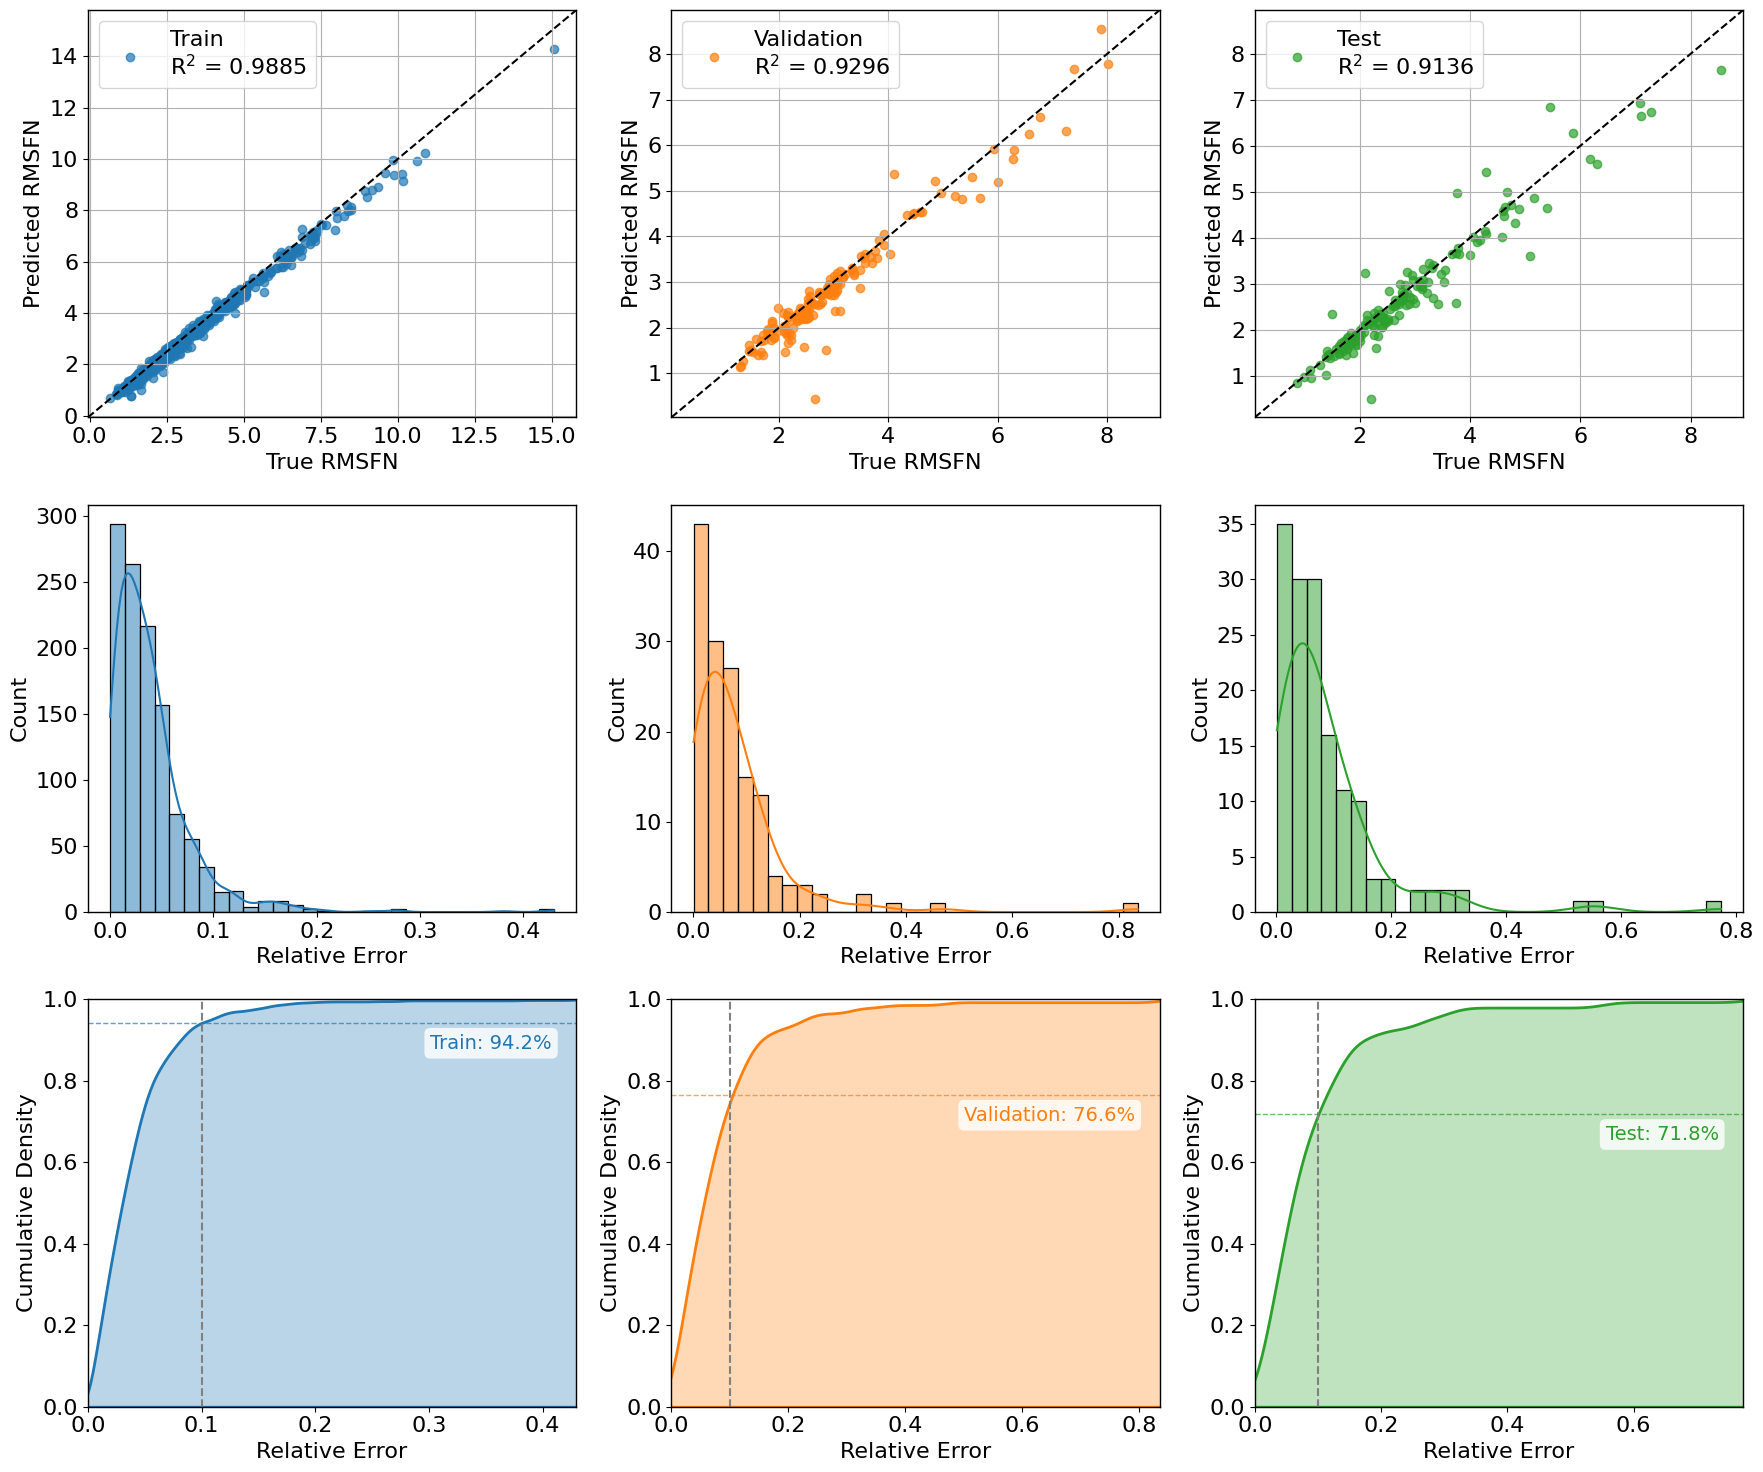

In [86]:
from sklearn.metrics import r2_score  # Import R² function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Dictionary to store results for each split
results = {split: {"target_RMS": [], "pred_RMS": [], "r2": None, "rel_error_RMS": [], "indices": []} for split in splits}

# Compute RMS Frobenius norms, R², and relative error for each split
for split_name, idx in splits.items():
    target_RMS_list = []
    pred_RMS_list = []
    rel_error_list = []
    indices_list = []
    
    for index, row in df.iloc[idx].iterrows():
        target = row["real_Permittivity_Matrices_interp"]  # Shape: (201, 3, 3)
        pred = row["y_pred_cart"]  # Shape: (201, 3, 3)

        # Compute Frobenius norm for each omega slice
        frobenius_target = [np.linalg.norm(target[i]) for i in range(target.shape[0])]
        frobenius_pred = [np.linalg.norm(pred[i]) for i in range(pred.shape[0])]

        # Compute RMS Frobenius Norm for target and pred
        target_RMS = np.sqrt(np.mean(np.square(frobenius_target)))
        pred_RMS = np.sqrt(np.mean(np.square(frobenius_pred)))

        # Compute relative error (normalized by target RMS)
        if target_RMS != 0:
            rel_error = np.abs(target_RMS - pred_RMS) / target_RMS
        else:
            rel_error = np.nan  # If target_RMS is zero, avoid division by zero

        # Store values
        target_RMS_list.append(target_RMS)
        pred_RMS_list.append(pred_RMS)
        rel_error_list.append(rel_error)
        indices_list.append(index)

    # Convert lists to NumPy arrays
    target_RMS_array = np.array(target_RMS_list)
    pred_RMS_array = np.array(pred_RMS_list)
    rel_error_array = np.array(rel_error_list)

    # Compute R² score
    r2 = r2_score(target_RMS_array, pred_RMS_array)
    
    # Store results
    results[split_name]["target_RMS"] = target_RMS_array
    results[split_name]["pred_RMS"] = pred_RMS_array
    results[split_name]["r2"] = r2
    results[split_name]["rel_error_RMS"] = rel_error_array
    results[split_name]["indices"] = indices_list

# Store rel_error in the DataFrame
for split_name, data in results.items():
    indices = data["indices"]
    rel_error_values = data["rel_error_RMS"]
    # Assign relative error values to the corresponding indices in df
    df.loc[indices, "rel_error_RMS"] = rel_error_values

# Create 3x3 panel plots (Scatter, Histogram, CDF)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Colors for each split
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# First row: Scatter plots
for i, (split_name, data) in enumerate(results.items()):
    target_RMS_array = data["target_RMS"]
    pred_RMS_array = data["pred_RMS"]
    r2 = data["r2"]
    
    # Scatter plot
    axes[0, i].scatter(target_RMS_array, pred_RMS_array, alpha=0.7, color=colors[split_name], label=f"{split_name}\n$R^2$ = {r2:.4f}")
    axes[0, i].set_xlabel("True RMSFN")
    axes[0, i].set_ylabel("Predicted RMSFN")
    axes[0, i].grid(True)
    
    # Add y = x reference line
    min_val = min(min(target_RMS_array), min(pred_RMS_array))
    max_val = max(max(target_RMS_array), max(pred_RMS_array))
    
    buffer = (max_val - min_val) * 0.05  # 5% buffer
    min_val -= buffer
    max_val += buffer
    
    axes[0, i].set_xlim(min_val, max_val)
    axes[0, i].set_ylim(min_val, max_val)
    
    # Draw the y = x line within this range
    x_vals = np.linspace(min_val, max_val, 100)
    axes[0, i].plot(x_vals, x_vals, linestyle='--', color='black')
    axes[0, i].legend(fontsize=16)

# Second row: Histograms (plotting relative error)
for i, (split_name, data) in enumerate(results.items()):
    rel_error = data["rel_error_RMS"]
    
    # Histogram with KDE
    sns.histplot(rel_error, bins=30, kde=True, color=colors[split_name], edgecolor="black", ax=axes[1, i])
    axes[1, i].set_xlabel('Relative Error', fontsize=16)
    if i == 0:
        axes[1, i].set_ylabel("Count", fontsize=16)

# Third row: Separate CDF plots for each split
threshold = 0.1  # Threshold for relative error
perc_tr = np.mean(results["Train"]["rel_error_RMS"] < threshold) * 100
perc_va = np.mean(results["Validation"]["rel_error_RMS"] < threshold) * 100
perc_te = np.mean(results["Test"]["rel_error_RMS"] < threshold) * 100

y_offsets = [-0.05, -0.05, -0.05]  # Larger offsets to separate the text
for i, (split_name, data) in enumerate(results.items()):
    rel_error = data["rel_error_RMS"]
    xmax = max(rel_error)

    color = colors[split_name]
    perc = {"Train": perc_tr, "Validation": perc_va, "Test": perc_te}[split_name]

    # Plot cumulative density of relative errors
    sns.kdeplot(rel_error, fill=True, color=color, cumulative=True, label=split_name, alpha=0.3, linewidth=2, bw_adjust=0.5, ax=axes[2, i])

    # Add vertical and horizontal lines
    axes[2, i].axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
    axes[2, i].axhline(y=perc/100, color=color, linestyle='--', linewidth=1, alpha=0.7)

    # Annotate the percentage with a background box
    x_annotate = xmax * 0.95  # Near the right edge
    y_pos = perc / 100 + y_offsets[i]  # Position at the percentage value
    axes[2, i].text(x_annotate, y_pos, f'{split_name}: {perc:.1f}%', color=color, fontsize=14, ha='right', va='center',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    # Customize the plot
    axes[2, i].set_xlim(0, xmax)
    axes[2, i].set_ylim(0, 1)
    axes[2, i].set_xlabel('Relative Error', fontsize=16)
    axes[2, i].set_ylabel('Cumulative Density', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()


/tmp/ipykernel_1094681/3648679432.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name
/tmp/ipykernel_1094681/3648679432.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


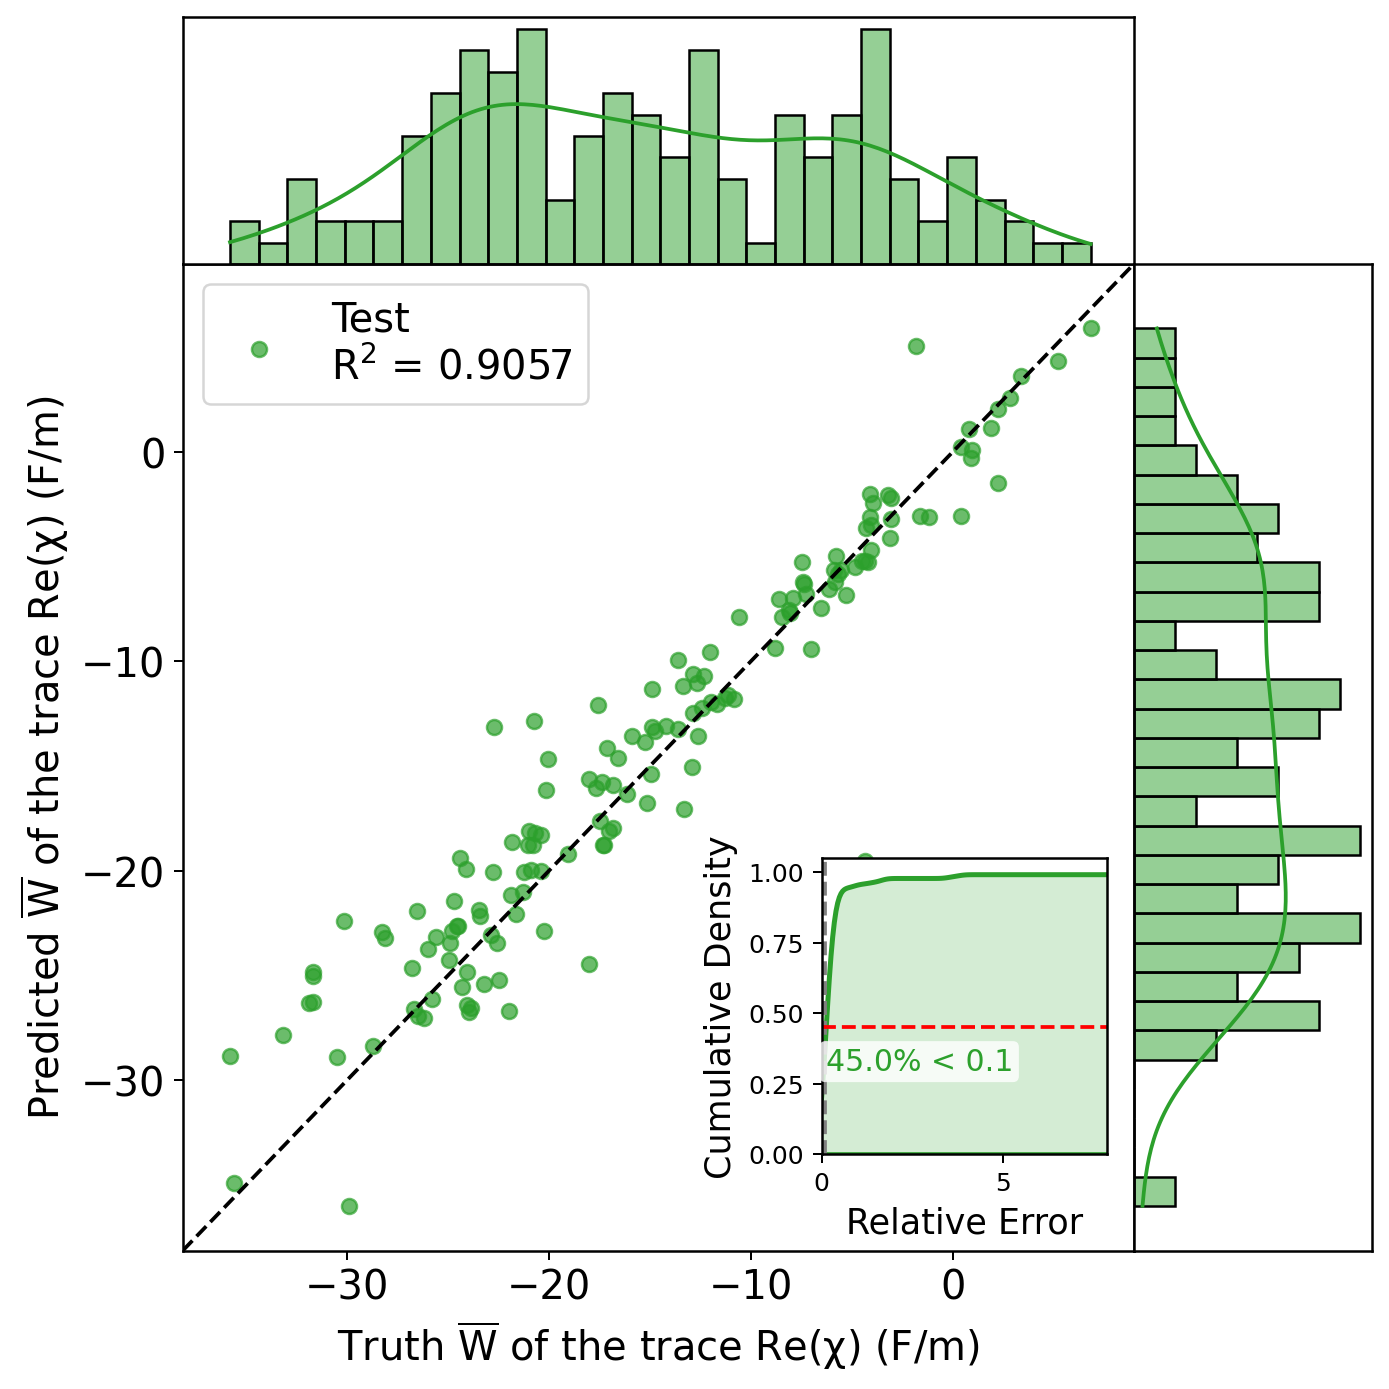

Train:
  R² = 0.9699
  Mean abs_diff = 1.1522
Validation:
  R² = 0.8927
  Mean abs_diff = 2.1285
Test:
  R² = 0.9057
  Mean abs_diff = 2.0701


In [87]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Add a 'split' column to df to label each row with its split
df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name

# Compute weighted mean of the trace (bar{W}) for true and predicted permittivity
def weighted_trace_mean(spectra, omegas):
    traces = np.trace(spectra, axis1=1, axis2=2)  # Shape (N,)
    numerator = np.sum(traces * omegas)
    denominator = np.sum(traces)
    return numerator / denominator if denominator != 0 else np.nan

# Extract frequency array (assumes same for all rows)
omega = df.iloc[0]['energies_interp']  # Must be shape (201,) or similar

# Apply the function to get bar{W} for true and predicted
df['target_barW'] = df["real_Permittivity_Matrices_interp"].apply(lambda x: weighted_trace_mean(x, omega))
df['pred_barW'] = df["y_pred_cart"].apply(lambda x: weighted_trace_mean(x, omega))
df['abs_diff'] = np.abs(df['target_barW'] - df['pred_barW'])

# Compute R² for each split
for split_name in splits:
    split_df = df[df['split'] == split_name]
    r2 = r2_score(split_df['target_barW'], split_df['pred_barW'])
    df.loc[df['split'] == split_name, 'r2_split'] = r2

# Create a scatter plot with marginal histograms for the Test set
fig = plt.figure(figsize=(8, 8), dpi=180)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      wspace=0.00, hspace=0.00)

# Define colors
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# Extract Test set data directly from df
test_df = df[df['split'] == 'Test']
target_barW = test_df['target_barW']
pred_barW = test_df['pred_barW']
r2 = test_df['r2_split'].iloc[0]  # The R² score for the Test set
abs_diff = test_df['abs_diff']


# Main scatter plot
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(target_barW, pred_barW, alpha=0.7, color=colors["Test"], label=f"Test\n$R^2$ = {r2:.4f}")
ax_scatter.set_xlabel(r"Truth $\overline{W}$ of the trace $Re(\chi)$ (F/m)", fontsize=16)
ax_scatter.set_ylabel(r"Predicted $\overline{W}$ of the trace $Re(\chi)$ (F/m)", fontsize=16)

# Add y = x reference line
min_val = min(min(target_barW), min(pred_barW))
max_val = max(max(target_barW), max(pred_barW))
buffer = (max_val - min_val) * 0.05
min_val -= buffer
max_val += buffer
ax_scatter.set_xlim(min_val, max_val)
ax_scatter.set_ylim(min_val, max_val)
x_vals = np.linspace(min_val, max_val, 100)
ax_scatter.plot(x_vals, x_vals, linestyle='--', color='black')
ax_scatter.legend(fontsize=16, loc='upper left', bbox_to_anchor=(0, 1.0))

# Top histogram (x-axis: True RMSFN)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(target_barW, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histx)
ax_histx.set_ylabel("")  # Already hidden
ax_histx.set_xlabel("")  # Explicitly hide the x-axis label (removes "target_RMS")
ax_histx.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histx.tick_params(axis='y', which='both', left=False, labelleft=False)

# Right histogram (y-axis: Predicted RMSFN)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=pred_barW, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histy)
ax_histy.set_xlabel("")  # Already hidden
ax_histy.set_ylabel("")  # Explicitly hide the y-axis label (removes "pred_RMS")
ax_histy.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add inset KDE plot for abs_diff
# Compute relative error
epsilon = 1e-8
rel_error = np.abs((pred_barW - target_barW) / (np.abs(target_barW) + epsilon))

# Add inset KDE plot for relative error
inset_ax = inset_axes(ax_scatter, width="30%", height="30%", loc='lower right',
                      bbox_to_anchor=(-0.01, 0.08, 1, 1), bbox_transform=ax_scatter.transAxes)

sns.kdeplot(rel_error, color=colors["Test"], ax=inset_ax, linewidth=2,
            bw_adjust=0.5, fill=True, cumulative=True, alpha=0.2)

inset_ax.set_xlabel(r'Relative Error', fontsize=14)
inset_ax.set_ylabel('Cumulative Density', fontsize=14)
inset_ax.tick_params(axis='both', labelsize=10)
inset_ax.set_xlim(0, np.max(rel_error) * 0.95)

# Define threshold and compute percentage below it
threshold = 0.1  # Change as needed
perc_te = np.mean(rel_error < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_te/100, color='red', linestyle='--', linewidth=1.5)
inset_ax.text(threshold + 0.01, perc_te / 100 - 0.07,
              f'{perc_te:.1f}% < {threshold}',
              color=colors["Test"], fontsize=12, ha='left', va='top',
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Display summary statistics
for split_name in splits:
    split_df = df[df['split'] == split_name]
    print(f"{split_name}:")
    print(f"  R² = {split_df['r2_split'].iloc[0]:.4f}")
    print(f"  Mean abs_diff = {split_df['abs_diff'].mean():.4f}")


/tmp/ipykernel_1094681/2030495850.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name
/tmp/ipykernel_1094681/2030495850.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


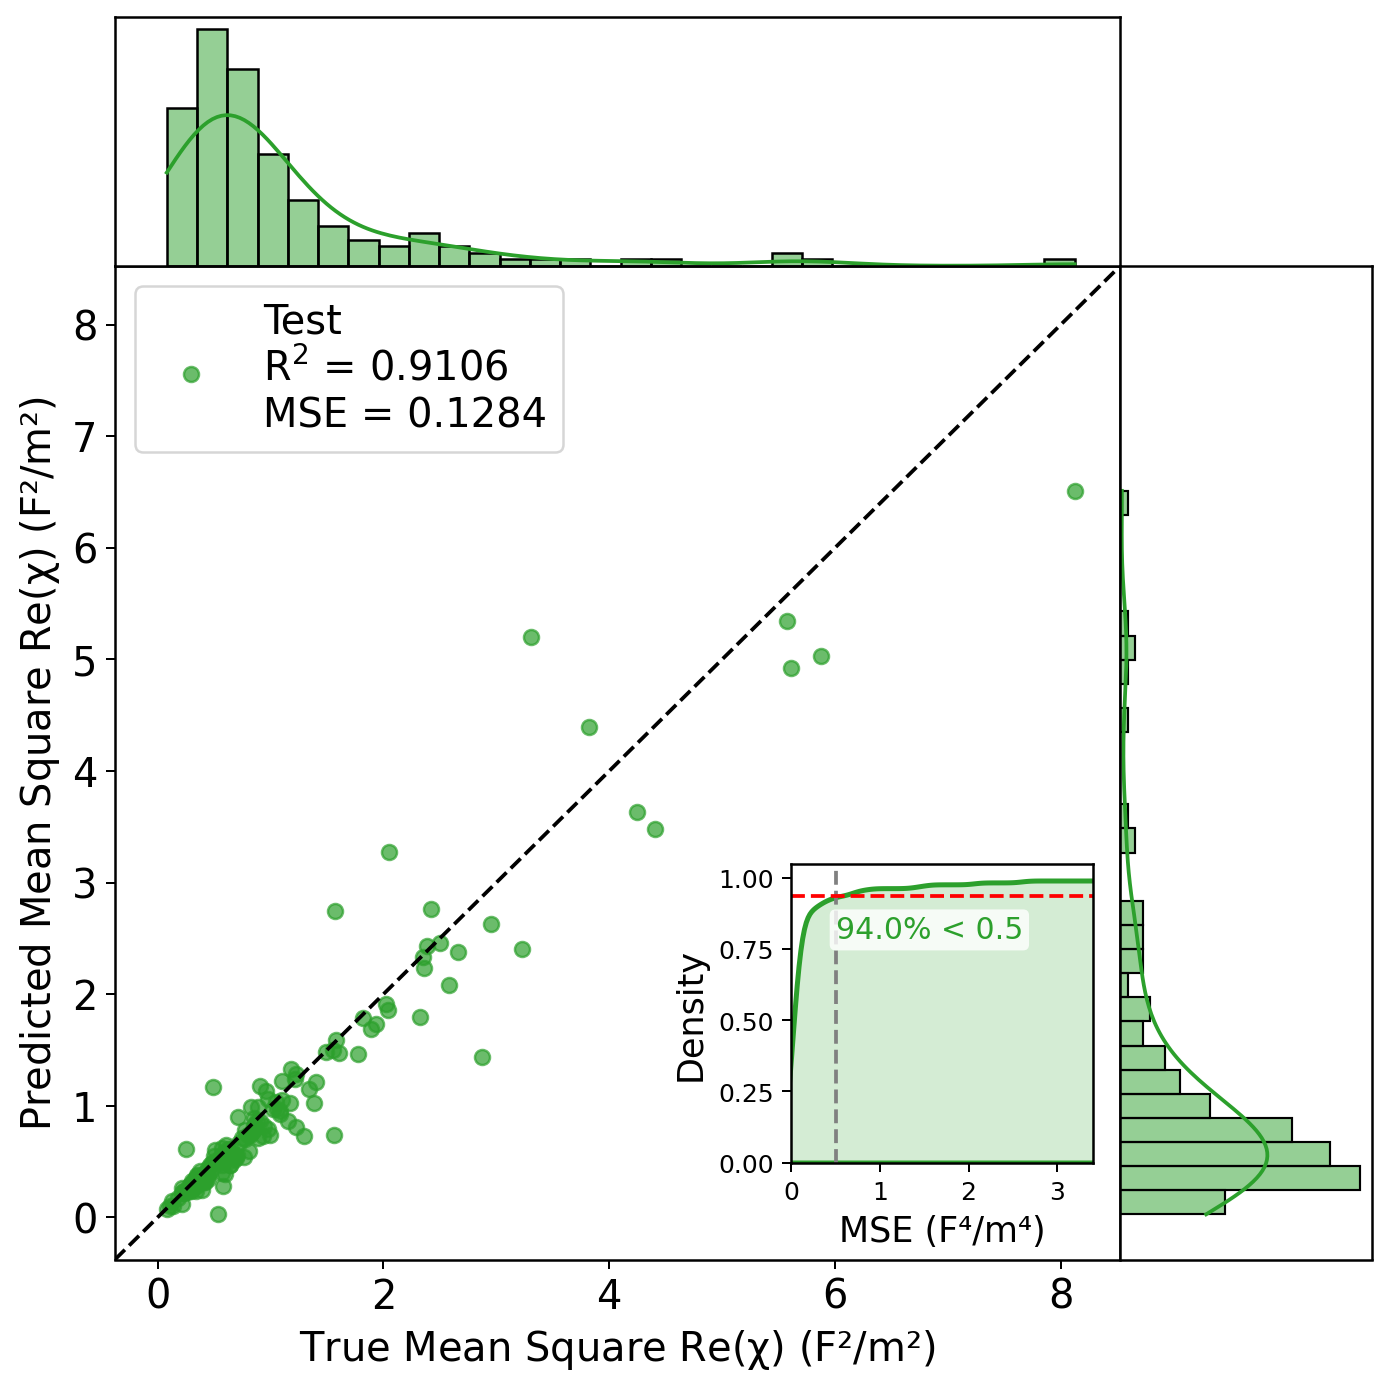

Train:
  R² = 0.9852
  Mean MSE = 0.0410
Validation:
  R² = 0.9486
  Mean MSE = 0.0865
Test:
  R² = 0.9106
  Mean MSE = 0.1284


In [88]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Add a 'split' column to df to label each row with its split
df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name

# Compute mean square and mean over components for target and predicted tensors
# Assuming tensor shape is [201, 3, 3], we'll flatten the [3, 3] components per energy step
df['target_mean_square'] = df["real_Permittivity_Matrices_interp"].apply(
    lambda x: np.mean(np.square(x))  # Mean of squared values over all components
)
df['pred_mean_square'] = df["y_pred_cart"].apply(
    lambda x: np.mean(np.square(x))  # Mean of squared values over all components
)
df['target_mean'] = df["real_Permittivity_Matrices_interp"].apply(
    lambda x: np.mean(x)  # Mean over all components
)
df['pred_mean'] = df["y_pred_cart"].apply(
    lambda x: np.mean(x)  # Mean over all components
)

# Compute MSE between mean square values for each sample
df['mse'] = (df['target_mean_square'] - df['pred_mean_square']) ** 2

# Compute R² for mean square values for each split
for split_name in splits:
    split_df = df[df['split'] == split_name]
    r2 = r2_score(split_df['target_mean_square'], split_df['pred_mean_square'])
    df.loc[df['split'] == split_name, 'r2_split'] = r2

# Create a scatter plot with marginal histograms for the Test set
fig = plt.figure(figsize=(8, 8), dpi=180)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      wspace=0.00, hspace=0.00)

# Define colors
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# Extract Test set data directly from df
test_df = df[df['split'] == 'Test']
target_ms = test_df['target_mean_square']
pred_ms = test_df['pred_mean_square']
r2 = test_df['r2_split'].iloc[0]
mse_values = test_df['mse']
mse_avg = mean_squared_error(target_ms, pred_ms)  # Average MSE for the Test set

# Main scatter plot using mean square values
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(target_ms, pred_ms, alpha=0.7, color=colors["Test"], 
                   label=f"Test\n$R^2$ = {r2:.4f}\nMSE = {mse_avg:.4f}")
ax_scatter.set_xlabel(r"True Mean Square $Re(\chi)$ (F²/m²)", fontsize=16)
ax_scatter.set_ylabel(r"Predicted Mean Square $Re(\chi)$ (F²/m²)", fontsize=16)

# Add y = x reference line
min_val = min(min(target_ms), min(pred_ms))
max_val = max(max(target_ms), max(pred_ms))
buffer = (max_val - min_val) * 0.05
min_val -= buffer
max_val += buffer
ax_scatter.set_xlim(min_val, max_val)
ax_scatter.set_ylim(min_val, max_val)
x_vals = np.linspace(min_val, max_val, 100)
ax_scatter.plot(x_vals, x_vals, linestyle='--', color='black')
ax_scatter.legend(fontsize=16, loc='upper left', bbox_to_anchor=(0, 1.0))

# Top histogram (x-axis: True Mean Square)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(target_ms, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histx)
ax_histx.set_ylabel("")
ax_histx.set_xlabel("")
ax_histx.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histx.tick_params(axis='y', which='both', left=False, labelleft=False)

# Right histogram (y-axis: Predicted Mean Square)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=pred_ms, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histy)
ax_histy.set_xlabel("")
ax_histy.set_ylabel("")
ax_histy.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add inset KDE plot for MSE
inset_ax = inset_axes(ax_scatter, width="30%", height="30%", loc='lower right', 
                      bbox_to_anchor=(-0.01, 0.08, 1, 1), bbox_transform=ax_scatter.transAxes)
sns.kdeplot(mse_values, color=colors["Test"], ax=inset_ax, linewidth=2, bw_adjust=0.5, 
            fill=True, cumulative=True, alpha=0.2)
inset_ax.set_xlabel(r'MSE (F⁴/m⁴)', fontsize=14)  # Units reflect squared mean square
inset_ax.set_ylabel('Density', fontsize=14)
inset_ax.tick_params(axis='both', labelsize=10)
inset_ax.set_xlim(0, max(mse_values) * 0.95)

# Define threshold and compute percentage
threshold = 0.5  # Adjusted for mean square MSE (smaller due to squared units)
perc_te = np.mean(mse_values < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_te/100, color='red', linestyle='--', linewidth=1.5)
inset_ax.text(threshold + 0.002, perc_te / 100 - 0.07, f'{perc_te:.1f}% < {threshold}', 
              color=colors["Test"], fontsize=12, ha='left', va='top', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Display summary statistics
for split_name in splits:
    split_df = df[df['split'] == split_name]
    print(f"{split_name}:")
    print(f"  R² = {split_df['r2_split'].iloc[0]:.4f}")
    print(f"  Mean MSE = {split_df['mse'].mean():.4f}")

/tmp/ipykernel_1094681/565283329.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'split'] = split_name
/tmp/ipykernel_1094681/565283329.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


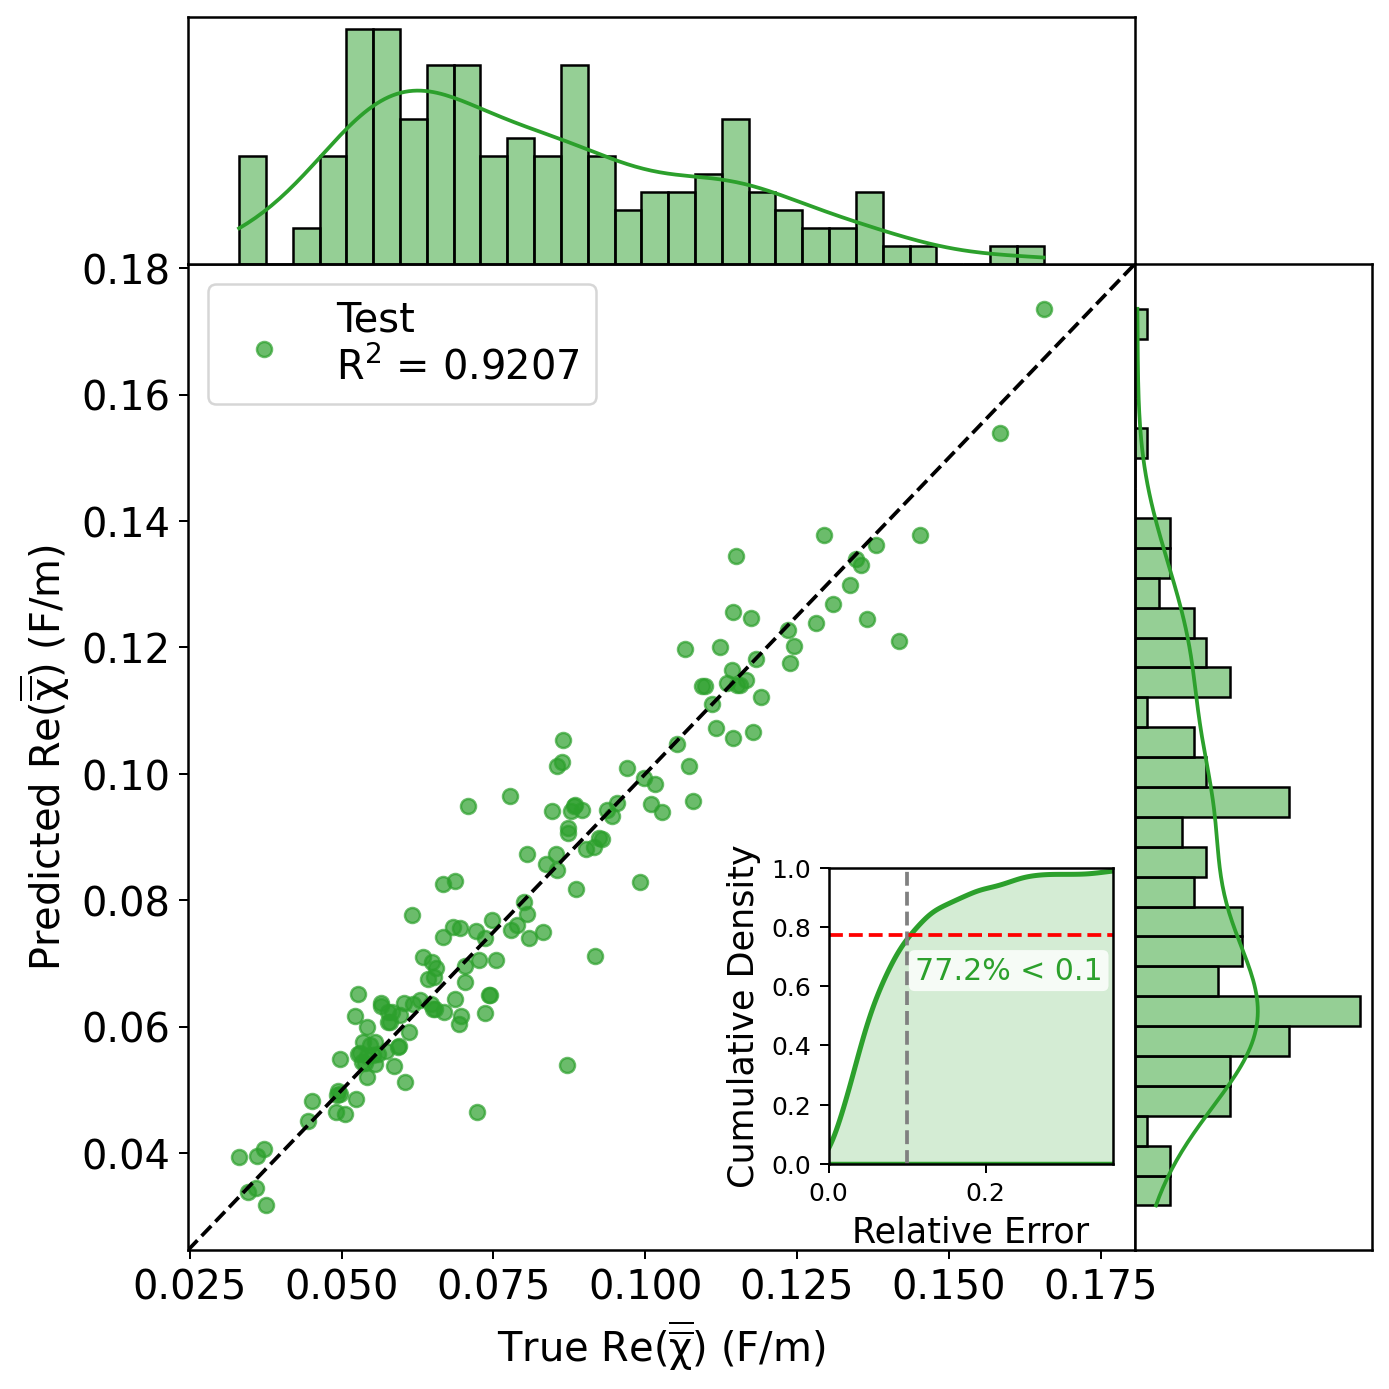

Train:
  R² = 0.9793
  Mean abs_diff = 0.0031
Validation:
  R² = 0.8900
  Mean abs_diff = 0.0060
Test:
  R² = 0.9207
  Mean abs_diff = 0.0056


In [89]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming df contains all data and idx_train, idx_valid, idx_test are defined
splits = {
    "Train": idx_train,
    "Validation": idx_valid,
    "Test": idx_test
}

# Add a 'split' column to df to label each row with its split
df['split'] = np.nan
for split_name, idx in splits.items():
    df.loc[idx, 'split'] = split_name

# Compute the mean along dim=0 (energy dimension) for each [i,j] component
df['target_mean'] = df["real_Permittivity_Matrices_interp"].apply(
    lambda x: np.mean(x, axis=0)  # Mean over energy dimension (201)
)
df['pred_mean'] = df["y_pred_cart"].apply(
    lambda x: np.mean(x, axis=0)  # Mean over energy dimension (201)
)

# Compute the average over all components of the [3, 3] mean tensors
df['target_avg'] = df['target_mean'].apply(lambda x: np.mean(x))  # Average over all 9 components
df['pred_avg'] = df['pred_mean'].apply(lambda x: np.mean(x))      # Average over all 9 components

# Compute absolute difference between the averages
df['abs_diff_avg'] = np.abs(df['target_avg'] - df['pred_avg'])

# Extract Test set data
test_df = df[df['split'] == 'Test']
target_avg = test_df['target_avg'].values  # Shape: (num_test_samples,)
pred_avg = test_df['pred_avg'].values      # Shape: (num_test_samples,)
abs_diff_avg = test_df['abs_diff_avg'].values  # Shape: (num_test_samples,)

# Compute R² for the averaged values
r2 = r2_score(target_avg, pred_avg)

# Create a scatter plot with marginal histograms for the Test set
fig = plt.figure(figsize=(8, 8), dpi=180)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], 
                      wspace=0.00, hspace=0.00)

# Define colors
colors = {"Train": "#1f77b4", "Validation": "#ff7f0e", "Test": "#2ca02c"}

# Main scatter plot (average over components)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(target_avg, pred_avg, alpha=0.7, color=colors["Test"], 
                   label=f"Test\n$R^2$ = {r2:.4f}")
ax_scatter.set_xlabel(r"True $Re(\overline{\overline{\chi}}$) (F/m)", fontsize=16)
ax_scatter.set_ylabel(r"Predicted $Re(\overline{\overline{\chi}}$) (F/m)", fontsize=16)

# Add y = x reference line
min_val = min(min(target_avg), min(pred_avg))
max_val = max(max(target_avg), max(pred_avg))
buffer = (max_val - min_val) * 0.05
min_val -= buffer
max_val += buffer
ax_scatter.set_xlim(min_val, max_val)
ax_scatter.set_ylim(min_val, max_val)
x_vals = np.linspace(min_val, max_val, 100)
ax_scatter.plot(x_vals, x_vals, linestyle='--', color='black')
ax_scatter.legend(fontsize=16, loc='upper left', bbox_to_anchor=(0, 1.0))

# Top histogram (x-axis: True Avg)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(target_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histx)
ax_histx.set_ylabel("")
ax_histx.set_xlabel("")
ax_histx.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histx.tick_params(axis='y', which='both', left=False, labelleft=False)

# Right histogram (y-axis: Predicted Avg)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=pred_avg, bins=30, kde=True, color=colors["Test"], edgecolor="black", ax=ax_histy)
ax_histy.set_xlabel("")
ax_histy.set_ylabel("")
ax_histy.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_histy.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add inset KDE plot for relative error (using CDF)
epsilon = 1e-8  # Small value to prevent division by zero
rel_error = np.abs((target_avg - pred_avg) / (np.abs(target_avg) + epsilon))

# Compute relative error KDE
inset_ax = inset_axes(ax_scatter, width="30%", height="30%", loc='lower right', 
                      bbox_to_anchor=(-0.005, 0.07, 1, 1), bbox_transform=ax_scatter.transAxes)
sns.kdeplot(rel_error, color=colors["Test"], ax=inset_ax, linewidth=2, bw_adjust=0.5, 
            fill=True, cumulative=True, alpha=0.2)
inset_ax.set_xlabel('Relative Error', fontsize=14)
inset_ax.set_ylabel('Cumulative Density', fontsize=14)
inset_ax.tick_params(axis='both', labelsize=10)
inset_ax.set_xlim(0, np.max(rel_error) * 0.95)
inset_ax.set_ylim(0, 1)

# Define threshold and compute percentage
threshold = 0.1  # Adjust based on rel_error range
perc_te = np.mean(rel_error < threshold) * 100
inset_ax.axvline(x=threshold, color='gray', linestyle='--', linewidth=1.5)
inset_ax.axhline(y=perc_te / 100, color='red', linestyle='--', linewidth=1.5)
inset_ax.text(threshold + 0.01, perc_te / 100 - 0.07, f'{perc_te:.1f}% < {threshold}', 
              color=colors["Test"], fontsize=12, ha='left', va='top', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Display summary statistics for each split
for split_name in splits:
    split_df = df[df['split'] == split_name]
    split_target_avg = split_df['target_avg'].values
    split_pred_avg = split_df['pred_avg'].values
    split_r2 = r2_score(split_target_avg, split_pred_avg)
    print(f"{split_name}:")
    print(f"  R² = {split_r2:.4f}")
    print(f"  Mean abs_diff = {split_df['abs_diff_avg'].mean():.4f}")


In [90]:
from matplotlib.ticker import MaxNLocator

def format_chemical_formula(formula):
    if not formula:
        return formula
    result = ''
    i = 0
    while i < len(formula):
        char = formula[i]
        if char.isalpha():
            element = char
            i += 1
            if i < len(formula) and formula[i].islower():
                element += formula[i]
                i += 1
            result += element
            number = ''
            while i < len(formula) and formula[i].isdigit():
                number += formula[i]
                i += 1
            if number:
                result += f'_{{{number}}}'
            if i < len(formula) and formula[i] == '^':
                i += 1
                superscript = ''
                while i < len(formula) and (formula[i].isdigit() or formula[i] in ['+', '-']):
                    superscript += formula[i]
                    i += 1
                if superscript:
                    result += f'^{{{superscript}}}'
        else:
            result += char
            i += 1
    return result

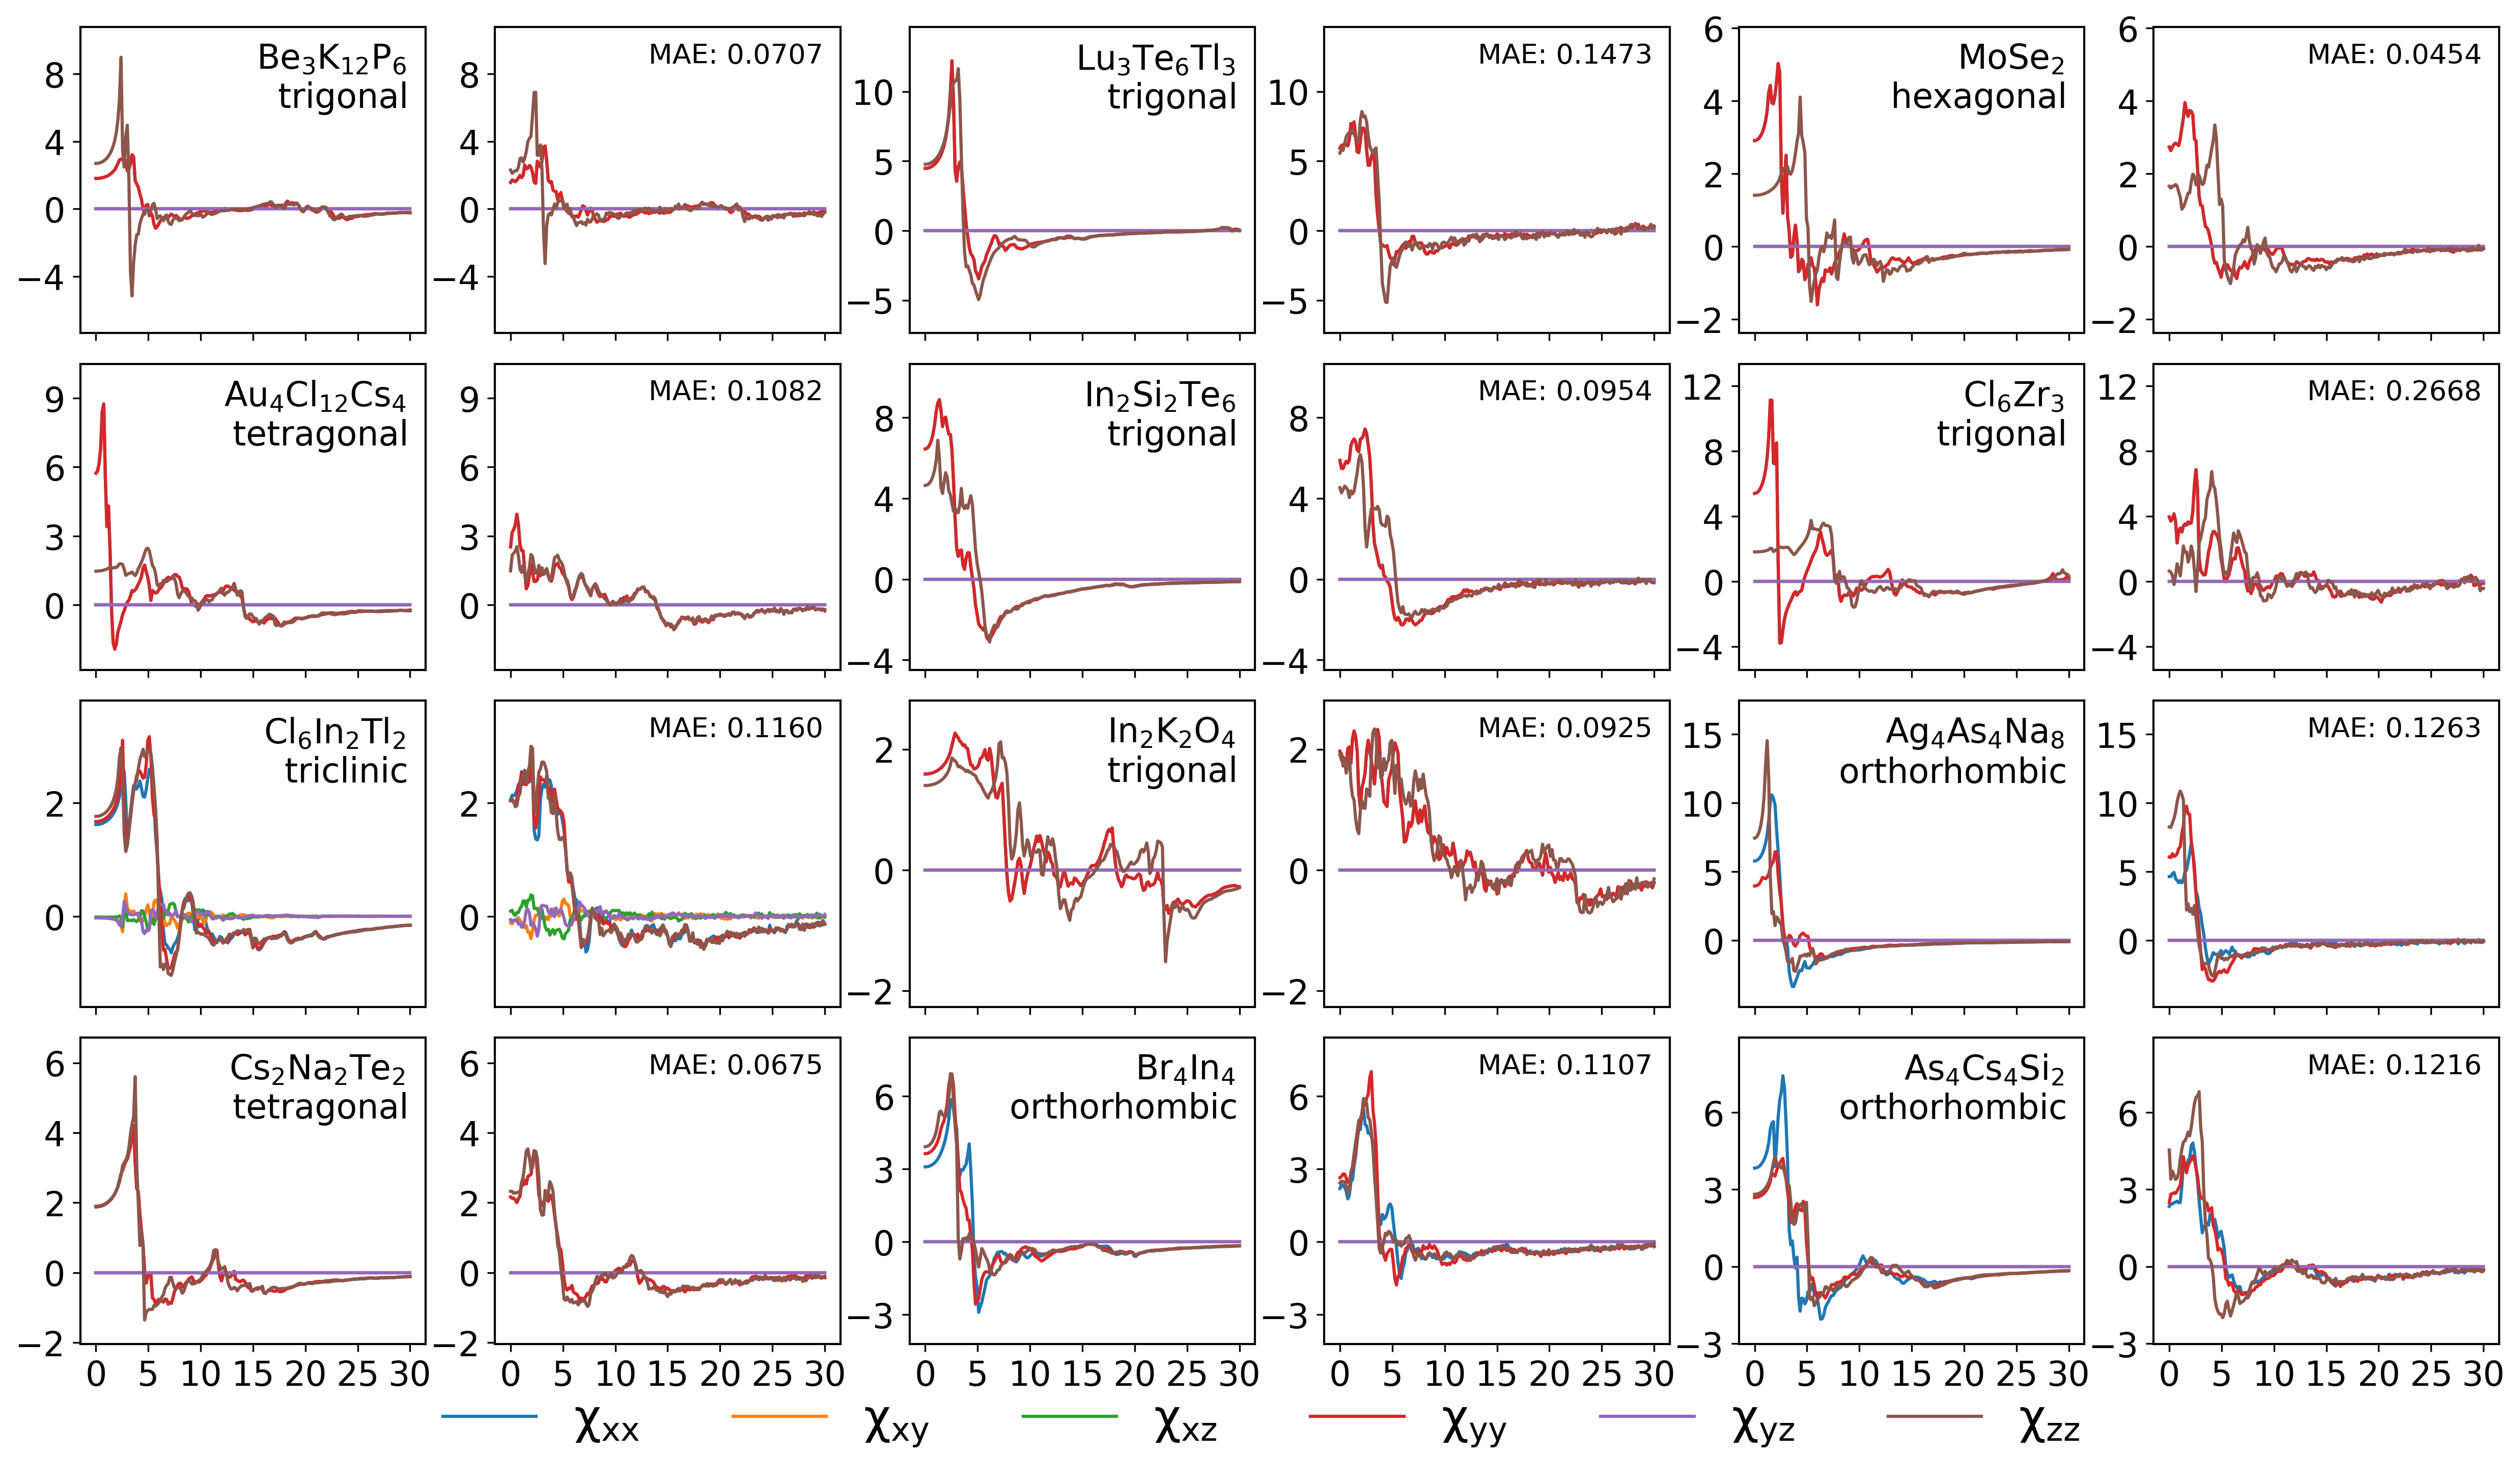

In [91]:
n_samples = 12
def get_random_sample_indices(idx, n):
    """Returns `n` randomly selected unique indices from `idx`."""
    if len(idx) < n:
        n = len(idx)  # Ensure we don't exceed available samples
    return np.random.choice(idx, size=n, replace=False)

random_idx_test = get_random_sample_indices(idx_test, n_samples)


def plot_cartesian_tensor_comparison(df, idx, column_name, title_prefix="", n=3):
    """
    Plots multiple side-by-side line plots comparing predicted vs. real Cartesian tensors 
    in a more compact horizontal layout with minimal white space.

    Parameters:
    - df: Pandas DataFrame containing 'y_pred_cart' (predictions), 
          'real_Permittivity_Matrices_interp' (targets), and 'energies_interp'.
    - idx: List or array of indices to consider (e.g., idx_train, idx_test).
    - title_prefix: Prefix to be added to the plot title.
    - n: Number of samples to plot.
    """
    # Filter DataFrame based on provided indices
    ds = df.iloc[idx].reset_index(drop=True)

    # Define component labels
    xyz_list = ['x', 'y', 'z']
    tensor_components = [f"$\chi_{{{xyz_list[a]}{xyz_list[b]}}}$" for a in range(3) for b in range(a, 3)]

    # Define subplot grid layout
    n_rows = min(n, 4)  # Limit number of rows to at most 4
    n_cols = math.ceil(n / n_rows) * 2  # Ensures space for real & predicted pairs

    # Adjust figure size to reduce white space
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8 * n_cols, 2.5 * n_rows), dpi=300, sharex=True)
    axes = axes.ravel()  # Flatten axes array for easy iteration

    handles, labels = [], []

    for i, sample_idx in enumerate(idx[:n]):  # Directly loop over provided idx
        material_id = ds.iloc[i]['mp_id']
        # mse_cart = ds.iloc[i]['mse_cart']
        mae_cart = ds.iloc[i]['mae_cart']
        
        crystal_system = ds.iloc[i]['crystal_system']
        formula = ds.iloc[i]['formula']
        omega = ds["energies_interp"].iloc[i]
        formatted_formula = format_chemical_formula(formula)
        real_permittivity = ds[column_name].iloc[i]  # (num_energies, 3, 3)
        pred_permittivity = ds["y_pred_cart"].iloc[i]  # (num_energies, 3, 3)
        
        y_min = min(real_permittivity.min(), pred_permittivity.min())
        y_max = max(real_permittivity.max(), pred_permittivity.max())
        
        # Left subplot: Real permittivity
        ax_real = axes[2 * i]  # Every even index is real data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            h, = ax_real.plot(omega, real_permittivity[:, a, b], label=tensor_components[idx], linestyle='-')
            if i == 0:  # Collect legend items only from the first plot
                handles.append(h)
                labels.append(tensor_components[idx])
        if column_name =="real_Permittivity_Matrices_interp":
            ax_real.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_real.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        ax_real.text(0.95, 0.95, f"${formatted_formula}$ \n {crystal_system}", 
             transform=ax_real.transAxes, fontsize=16, verticalalignment='top', 
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        # ax_real.text(0.95, 0.95, r"${formatted_formula}$ \n {crystal_system}", transform=ax_real.transAxes, 
        #             fontsize=19, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        ax_real.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))

        # Right subplot: Predicted permittivity
        ax_pred = axes[2 * i + 1]  # Every odd index is predicted data
        for idx, (a, b) in enumerate([(x, y) for x in range(3) for y in range(x, 3)]):
            ax_pred.plot(omega, pred_permittivity[:, a, b], linestyle='-')
        if column_name =="real_Permittivity_Matrices_interp":
            ax_pred.set_ylim((y_min-0.1) * 1.4, y_max * 1.2)
        else:
            ax_pred.set_ylim((y_min-0.5) * 1.4, y_max * 1.2)
        # Format the text with fixed-width numbers and aligned labels
        # Use a monospace font and ensure consistent spacing
        text_str = (
            f"{'MAE:':<1} {mae_cart:>4.4f}\n"
        )

        # Add the text to the subplot
        ax_pred.text(
            0.95, 0.95,  # Position in axes coordinates (top-right)
            text_str,
            transform=ax_pred.transAxes,
            fontsize=13,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
        ax_pred.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        
    # Remove x-labels from individual subplots
    for ax in axes:
        ax.set_xticks([])
    
    for ax in axes[-n_cols:]:  
        ax.set_xticks(np.linspace(omega.min(), omega.max(), 7))

    # Add a single, global x-axis label
    # fig.supxlabel("Photon energy (eV)", fontsize=24)
    # fig.supylabel(r"Im $\chi_{ij}(\omega) (F/m)$", fontsize=24)

    # Add a single legend outside the figure
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=22, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
    plt.subplots_adjust(wspace=0.2, hspace=0.1)  

    os.makedirs("../pngs", exist_ok=True)
    save_path = f"../pngs/{title_prefix}_cart_spectra.png"
    fig.savefig(save_path, dpi=300)

    plt.show()

# random_idx_test = [ 435, 1118,  283, 1336,  436, 1418, 1201,   78]
# random_idx_test = [ 112, 1153, 1354,  1118,  238,   78,  959, 1303]
plot_cartesian_tensor_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)


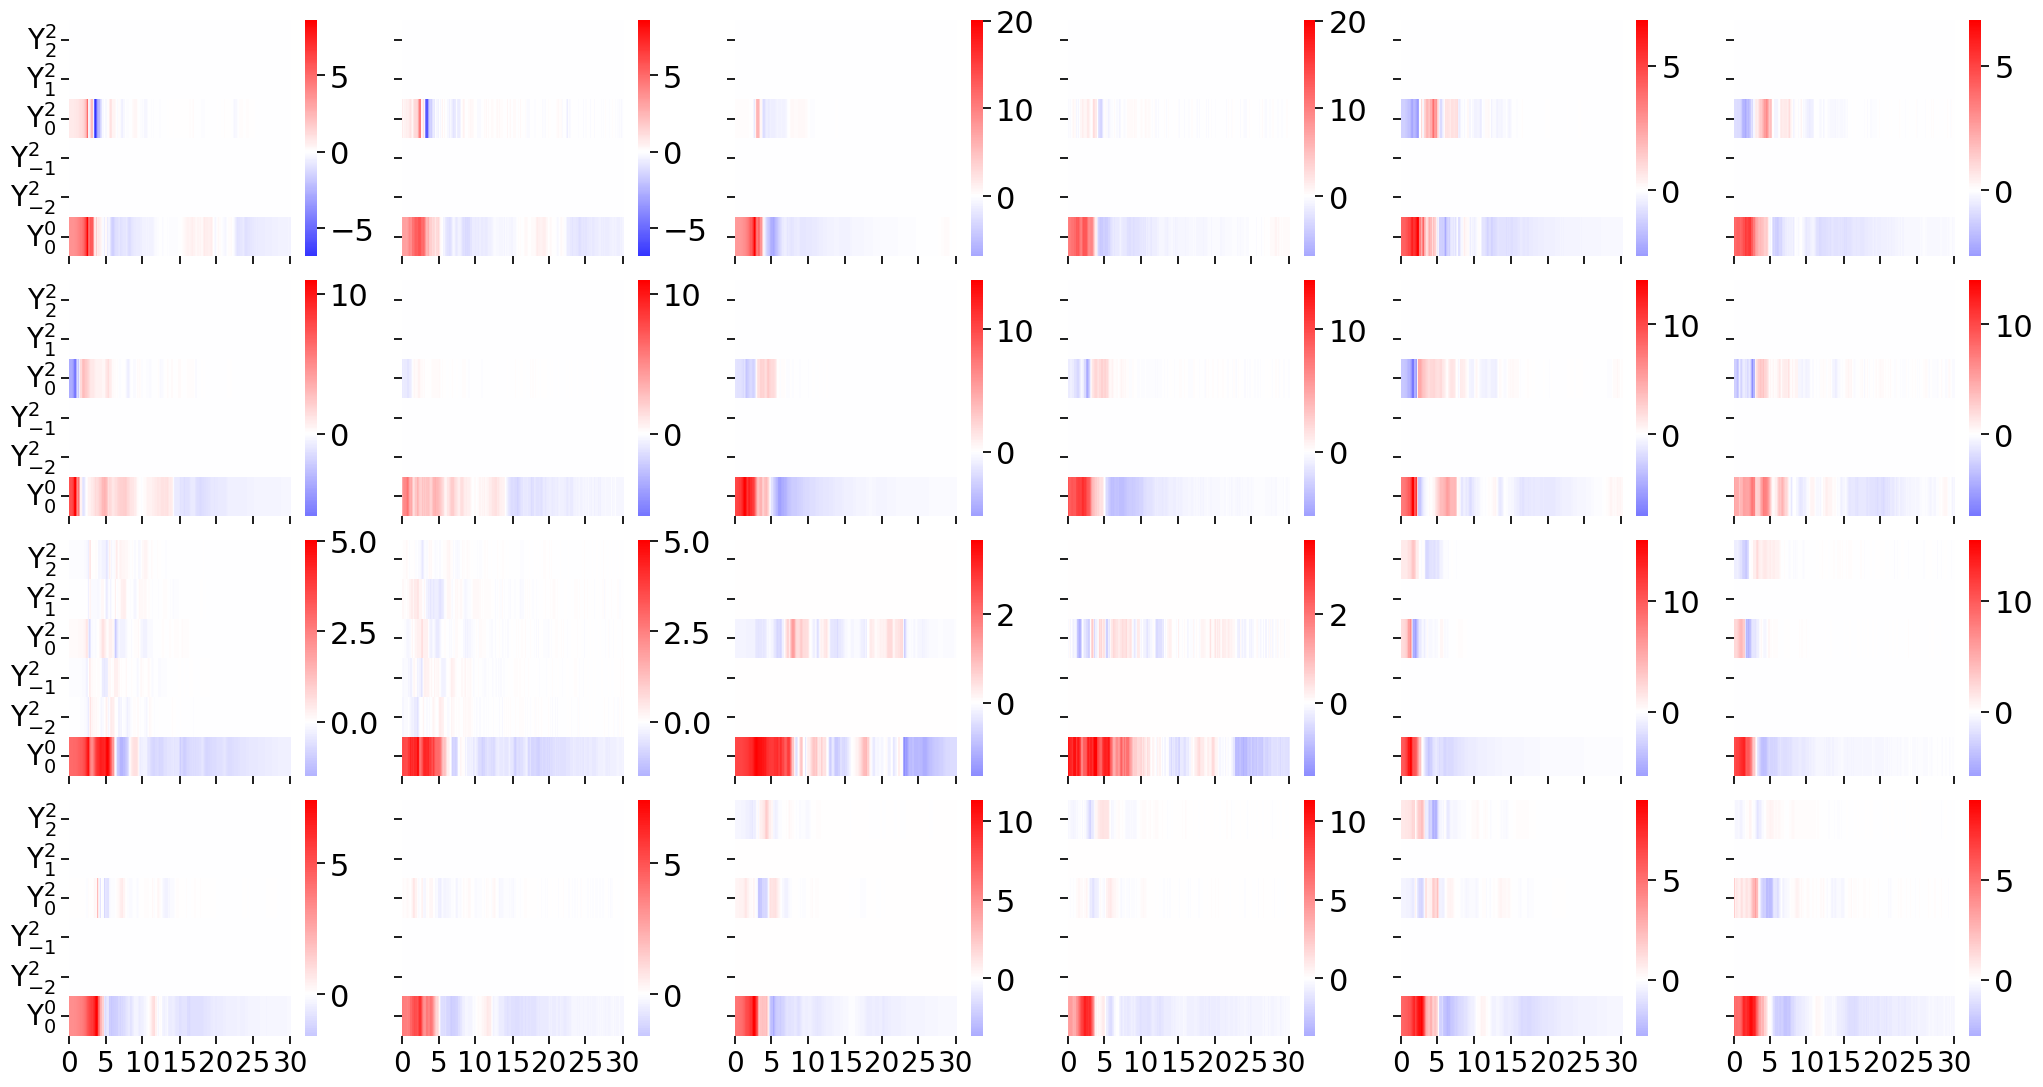

In [92]:
plot_spherical_harmonics_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)


Shape of MAE per omega (after averaging over samples): (201, 3, 3)

3x3 MAE Matrix (averaged over omega and dataset):
[[0.16210312 0.00191246 0.00984369]
 [0.00191246 0.16165046 0.0020782 ]
 [0.00984369 0.0020782  0.17931887]]


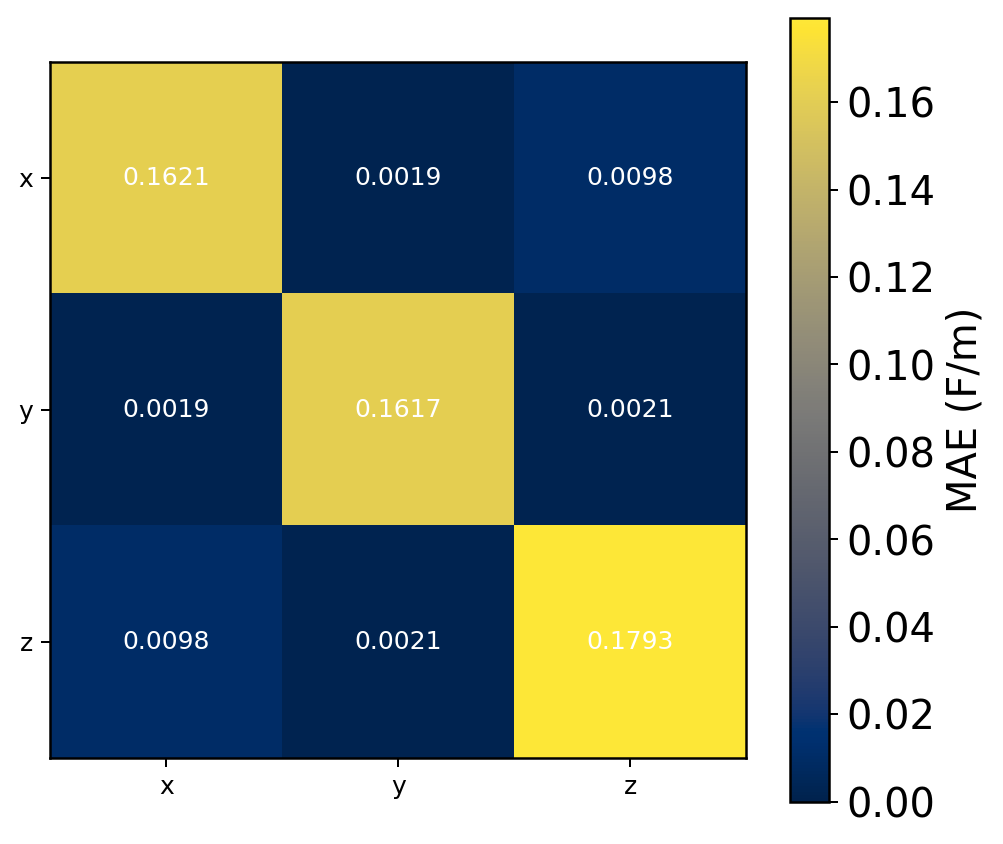


Summary Statistics:
Mean MAE across all components: 0.0590
Max MAE: 0.1793 at position (2, 2)
Min MAE: 0.0019 at position (0, 1)


In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df contains your data with 'real_Permittivity_Matrices_interp' and 'y_pred_cart'
# Shape of each tensor: [N_omega, 3, 3], e.g., [201, 3, 3]

# Step 1: Compute the absolute error (AE) per omega slice for each sample
# This will result in a [N_omega, 3, 3] array of absolute errors per sample
df['abs_error_per_omega'] = df.apply(
    lambda row: np.abs(row['real_Permittivity_Matrices_interp'] - row['y_pred_cart']), axis=1
)

# Step 2: Average the absolute errors across all samples to get a [N_omega, 3, 3] MAE array
# Stack all [N_omega, 3, 3] arrays from all samples and take the mean over the sample dimension
mae_per_omega = np.mean(np.stack(df['abs_error_per_omega'].values), axis=0)
print("Shape of MAE per omega (after averaging over samples):", mae_per_omega.shape)

# Step 3: Average over the omega dimension to get a single 3x3 MAE matrix
mae_3x3 = np.mean(mae_per_omega, axis=0)
print("\n3x3 MAE Matrix (averaged over omega and dataset):")
print(mae_3x3)

# Step 4: Visualize the 3x3 MAE matrix with imshow
plt.figure(figsize=(6, 5), dpi=180)
im = plt.imshow(mae_3x3, cmap='cividis', vmin=0)
# Colorbar shows MAE in F/m (since permittivity is in F/m, absolute error is also in F/m)
plt.colorbar(im, label=r'MAE (F/m)')
# Axis labels as x, y, z

plt.xticks([0, 1, 2], ['x', 'y', 'z'], fontsize=10)
plt.yticks([0, 1, 2], ['x', 'y', 'z'], fontsize=10)

# Add text annotations with MAE values
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{mae_3x3[i, j]:.4f}', ha='center', va='center', color='white', fontsize=10)

plt.tight_layout()
plt.show()

# Optional: Summary statistics
print("\nSummary Statistics:")
print(f"Mean MAE across all components: {np.mean(mae_3x3):.4f}")
print(f"Max MAE: {np.max(mae_3x3):.4f} at position {np.unravel_index(np.argmax(mae_3x3), mae_3x3.shape)}")
print(f"Min MAE: {np.min(mae_3x3):.4f} at position {np.unravel_index(np.argmin(mae_3x3), mae_3x3.shape)}")

In [94]:
wandb.finish()


# Equivariance Preservance

In [95]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor  # Import the converter
import numpy as np

sym_prec = 1e-2
tolerance = 1e-2
k = 0
N_samples = 40
sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
all_masks = []
for index, row in df.iterrows():
    # Convert ASE Atoms object to pymatgen Structure
    ase_atoms = row.symmetrized_structure  # This is your ASE Atoms object
    pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)
    
    # Now use the pymatgen Structure with SpacegroupAnalyzer
    sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
    refined_structure = sga_primitive.get_refined_structure()
    refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
    symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

    x = np.ones([3, 3])
    mask = np.zeros([3, 3])
    for op in symmetry_operations:
        R = op.rotation_matrix 
        mask += R @ x @ R.T
    mask /= len(symmetry_operations)
    all_masks.append(mask) 

    spectra = row["y_pred_cart"]  # Shape: (201, 3,3)
    # Check if each 3x3 tensor satisfies symmetry
    violations = []
    for i in range(spectra.shape[0]):  # Loop over omega
        S_matrix = spectra[i] # Reshape (9,) -> (3,3)
        # Check symmetry constraint
        residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
        max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask

        if max_deviation > tolerance:
            violations.append((i, max_deviation))
    sys = row["crystal_system"]
    # Print results
    if not violations:
        # print(f"Material {row['mp_id']} pass check")
        continue
    else:
        print(f"{index} Material {row['mp_id']} violates symmetry in {len(violations)} cases. {sys}")
        # for index, dev in violations[:5]:  # Print first few violations
        #     print(f"  - Row {index}: max deviation = {dev:.5e}")
df["symmetry_mask"] = all_masks


865 Material mp-866311 violates symmetry in 1 cases. tetragonal


In [96]:
df.head()

,folder,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,target_mean_square,pred_mean_square,target_mean,pred_mean,mse,target_avg,pred_avg,abs_diff_avg,abs_error_per_omega,symmetry_mask
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,1.010021,0.943775,"[[0.23523906605252995, 0.0, -8.243714199993719...","[[0.2375894439012258, 7.496531408784559e-20, 2...",0.004389,0.078385,0.078445,0.000060,"[[[0.29961153604572077, 5.004152657767352e-18,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,1.214197,1.240012,"[[0.1977957317233489, 7.043718094049385e-19, 1...","[[0.2146420424641026, 2.6676763084868802e-18, ...",0.000666,0.065480,0.069365,0.003885,"[[[0.04469497159370217, 1.232476699918614e-16,...","[[1.0000000000000002, 0.0, -3.700743415417188e..."
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,0.343284,0.272757,"[[0.1324039306586157, -1.9801579008627255e-24,...","[[0.12903982013289902, 3.802481564221425e-18, ...",0.004974,0.044135,0.043013,0.001121,"[[[0.16991015721012603, 2.365968397476358e-17,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,0.868282,0.862353,"[[0.18688538055300666, 0.0, -1.65127473028921e...","[[0.18849840645737567, -1.1289205935191492e-19...",0.000035,0.062094,0.062781,0.000686,"[[[0.12453961871699848, 1.0881129428428661e-17...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...,1.266174,1.234100,"[[0.15150450312656097, 0.0, 0.0005371144688242...","[[0.15235196165613907, 9.116983715431184e-19, ...",0.001029,0.050828,0.050243,0.000586,"[[[0.30457990714118033, 4.6727806146405126e-17...","[[1.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, ..."


folder                               /global/cfs/cdirs/m225/angush/materialProject/...
formula                                                                       O6Pd2Se2
symmetrized_structure                (Atom('Pd', [0.0, 0.0, 0.0], index=0), Atom('P...
mp_id                                                                        mp-545482
bandgap                                                                         1.0589
crystal_system                                                              monoclinic
omega                                [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...
real_Permittivity_Matrices           [[[2.5296291215795996, 0.16230643260790517, -0...
imag_Permittivity_Matrices           [[[-5.786461228617004e-19, 5.347708794079923e-...
Re_00                                [2.5296291215795996, 2.5296535153014865, 2.529...
Re_01                                [0.16230643260790517, 0.16230870684764753, 0.1...
Re_02                                [-0.00

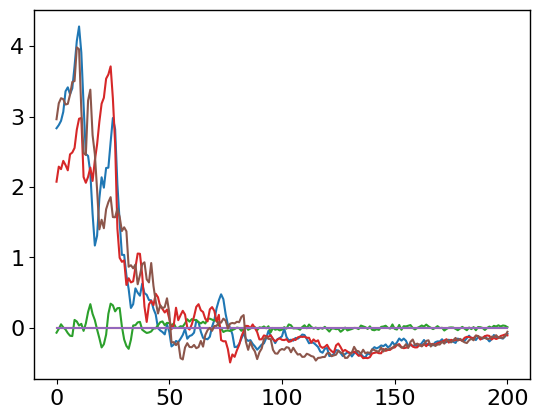

[[ 1.00000000e+00  0.00000000e+00 -9.36912883e-18]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.00000000e+00  0.00000000e+00  9.36912883e-18]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[-1.00000000e+00  0.00000000e+00  9.36912883e-18]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -9.36912883e-18]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [97]:
row = df.iloc[1271]
print(row)
print(row["crystal_system"])
spectra = row["y_pred_cart"]  # Shape: (201, 3,3)
mask = row["symmetry_mask"]
# Check if each 3x3 tensor satisfies symmetry
# violations = []
# for i in range(spectra.shape[0]):  # Loop over omega
#     S_matrix = spectra[i] # Reshape (9,) -> (3,3)
#     # Check symmetry constraint
#     print(S_matrix)
#     print(mask)
#     residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
#     print(residuals)
#     max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask
#     print(max_deviation)
#     if max_deviation > tolerance:
#         violations.append((i, max_deviation))
#     # Print results
#     if not violations:
#         # print(f"Material {row['mp_id']} pass check")
#         continue
#     else:
#         print(f"Material {row['mp_id']} violates symmetry in {len(violations)} cases.")
#         for index, dev in violations[:5]:  # Print first few violations
#             print(f"  - Row {index}: max deviation = {dev:.5e}")

for i in range(3):
    for j in range(i,3):
        plt.plot(spectra[:,i,j])
plt.show()

sym_prec = 1e-2
tolerance = 1e-2
k = 0
N_samples = 40
sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
# Convert ASE Atoms object to pymatgen Structure
ase_atoms = row.symmetrized_structure  # This is your ASE Atoms object
pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)

# Now use the pymatgen Structure with SpacegroupAnalyzer
sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
refined_structure = sga_primitive.get_refined_structure()
refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)

x = np.ones([3, 3])
mask = np.zeros([3, 3])
for op in symmetry_operations:
    R = op.rotation_matrix 
    print(R)
    mask += R @ x @ R.T
mask /= len(symmetry_operations)

spectra = row["y_pred_cart"]  # Shape: (201, 3,3)
# Check if each 3x3 tensor satisfies symmetry
violations = []
for i in range(spectra.shape[0]):  # Loop over omega
    S_matrix = spectra[i] # Reshape (9,) -> (3,3)
    # Check symmetry constraint
    residuals = S_matrix * (1 - mask)  # Keep only the disallowed values
    max_deviation = np.max(np.abs(residuals))  # Max deviation outside mask

    if max_deviation > tolerance:
        violations.append((i, max_deviation))



In [98]:
rotation_matrices = torch.tensor(np.array([op.rotation_matrix for op in symmetry_operations]))
print(rotation_matrices)
from e3nn.o3 import Irreps
irreps = Irreps("1x0e + 1x2e")

rot_tensors = irreps.D_from_matrix(rotation_matrices)

print(rot_tensors.shape)

tensor([[[ 1.0000e+00,  0.0000e+00, -9.3691e-18],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.0000e+00,  0.0000e+00,  9.3691e-18],
         [ 0.0000e+00, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-1.0000e+00,  0.0000e+00,  9.3691e-18],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00, -9.3691e-18],
         [ 0.0000e+00, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])
torch.Size([4, 6, 6])
